In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

print("CWD =", Path.cwd())

data_path = "./data"

CWD = /home/sylph/DataCantatio/pablocaicedor.github.io


# Importar datos

In [2]:
df = pd.read_csv(data_path+"/Injury_Risk/Injury_Risk.csv")

# Análisis exploratorio de datos

## Metadatos

### Entradas (X):

- **EMG_Quad_RMS_mV** (mV): RMS EMG cuádriceps.
- **EMG_Ham_RMS_mV** (mV): RMS EMG isquiotibiales.
- **GRF_Vert_Norm_BW** (BW): Fuerza de reacción vertical (normalizada).
- **Omega_Shank_deg_s** (deg/s): Velocidad angular de la pierna (IMU).
- **Hip_Flex_deg** (deg): Flexión de cadera.

### Objetivos (y):

- **Knee_Flex_deg** (deg): Ángulo de flexión de rodilla (regresión).
- **Risk_Lesion** (0/1): Riesgo alto de lesión (clasificación).

## 1. Información Inicial

- Identificar tipo de variable: numérica, categórica, ordinal, binaria.
- Establecer unidad de análisis (por sujeto o por medición).
- Documentar el diccionario de variables.

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EMG_Quad_RMS_mV    1000 non-null   float64
 1   EMG_Ham_RMS_mV     1000 non-null   float64
 2   GRF_Vert_Norm_BW   1000 non-null   float64
 3   Omega_Shank_deg_s  1000 non-null   float64
 4   Hip_Flex_deg       1000 non-null   float64
 5   Knee_Flex_deg      1000 non-null   float64
 6   Risk_Lesion        1000 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 54.8 KB


In [4]:
df.describe()


,EMG_Quad_RMS_mV,EMG_Ham_RMS_mV,GRF_Vert_Norm_BW,Omega_Shank_deg_s,Hip_Flex_deg,Knee_Flex_deg,Risk_Lesion
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.132759,0.106333,0.653127,-7.699962,14.705266,36.643233,0.203000
std,0.067192,0.055516,0.377876,229.191475,14.340497,36.987959,0.402434
min,0.021065,0.010611,0.000015,-399.477287,-9.998464,-5.000000,0.000000
25%,0.074274,0.055804,0.339756,-206.479384,2.248700,-1.671326,0.000000
50%,0.134266,0.108559,0.650798,-12.576573,14.729905,30.670564,0.000000
75%,0.191194,0.154488,0.986835,190.032648,26.999673,64.740941,0.000000
max,0.249935,0.199889,1.297167,399.646163,39.887469,129.670890,1.000000


In [5]:
df['Risk_Lesion'].value_counts(normalize=True)

Risk_Lesion
0    0.797
1    0.203
Name: proportion, dtype: float64

In [6]:

df.isna().sum()

EMG_Quad_RMS_mV      0
EMG_Ham_RMS_mV       0
GRF_Vert_Norm_BW     0
Omega_Shank_deg_s    0
Hip_Flex_deg         0
Knee_Flex_deg        0
Risk_Lesion          0
dtype: int64

## 2. Calidad de los datos

- Valores faltantes: porcentaje, patrón y manejo (eliminación, imputación o modelado).
- Cardinalidad irregular: detectar columnas con un solo valor o codificación errónea.
- Outliers: aplicar criterio de Tukey o z-score (>3σ).
-Validez contextual: verificar rangos fisiológicos (e.g., knee_flex_deg ∈ [0,180]).

<Axes: xlabel='Risk_Lesion', ylabel='Knee_Flex_deg'>

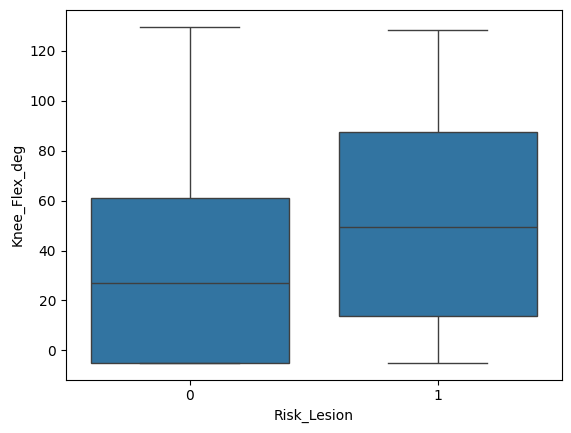

In [7]:
sns.boxplot(data=df, x='Risk_Lesion', y='Knee_Flex_deg')

<Axes: >

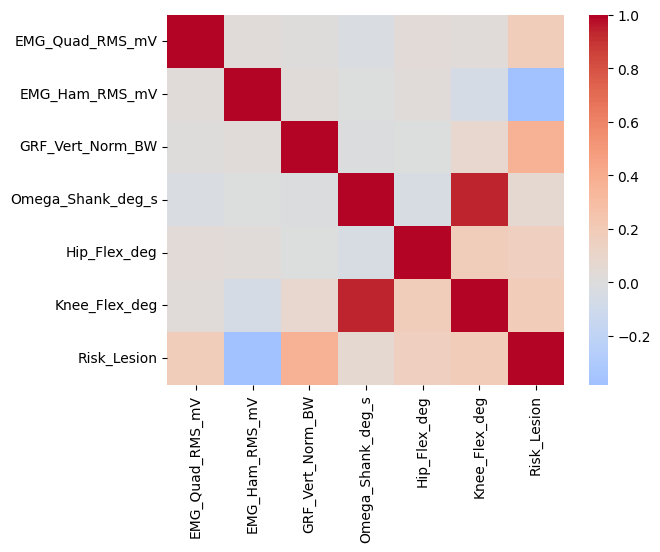

In [8]:
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', center=0)

## 3. Análisis univariado

- Variables numéricas: histograma, densidad, simetría, curtosis.
- Variables categóricas: frecuencia y proporciones.
- Objetivo de regresión: distribución y normalidad de knee_flex_deg.
- Objetivo de clasificación: balance de clases en Risk_Lesion.
- Indicadores sugeridos
    - Asimetría (skew), curtosis (kurt).
    - Test de normalidad: Shapiro–Wilk o Kolmogorov–Smirnov.
    - Detección de colas largas

## 4. Análisis bivariado

### 4.1 Regresión (knee_flex_deg)

- Correlaciones (Pearson/Spearman) entre knee_flex_deg y las variables predictoras.
- Dispersión y relación lineal/no lineal.
- Posibles transformaciones (log, sqrt, normalización z-score).

### 4.2 Clasificación (Risk_Lesion)

- Comparación de medias por grupo (t-test o ANOVA).
- Visualización de separación de clases: sns.pairplot(hue='Risk_Lesion').
- Matriz de correlación de variables relevantes para discriminación.

## 5. Análisis multivariado

- Reducción de dimensionalidad: PCA, t-SNE, o UMAP (para inspección visual).
- Evaluación de colinealidad: VIF > 5 sugiere eliminar variables redundantes.
- Mapeo estructural: identificar clústeres naturales y relaciones no lineales.

<Axes: >

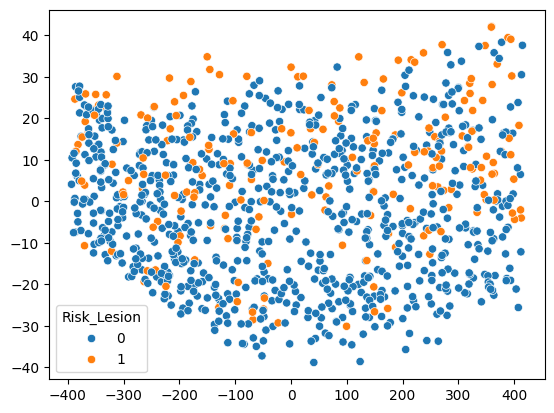

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(df.select_dtypes(float))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Risk_Lesion'])

## 6. Preparación del ABT (Analytical Base Table)

- Eliminar variables con >60% de valores nulos.
- Codificar variables categóricas (one-hot o label encoding).
- Escalar numéricas (StandardScaler o MinMaxScaler).
- Dividir entre train / test sin fuga de información.

## 7. EDA orientado al modelado

- Para regresión: identificar relaciones no lineales → explorar transformaciones de knee_flex_deg.
- Para clasificación: verificar separabilidad y métricas de desequilibrio (balanced_accuracy, AUC).

# 8. Descenso de gradiente

In [ ]:
def gradient(w, X, y):
    y_hat = X @ w
    resid = (y_hat - y)                 # (m,)
    grad_w0 = (2.0 / m) * np.sum(resid) # escalar
    grad_w1 = (2.0 / m) * np.sum(resid * X)
    return np.array([grad_w0, grad_w1])